In [2]:
import pandas as pd
import numpy as np
import random

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import svm as svm

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")
random.seed(1137)

In [3]:
austin = pd.read_csv('data/processed/austin_dv.csv')

# fill in missing ages with the median age
austin['age_days'].fillna(austin['age_days'].median(), inplace=True)

# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set.

y = austin[['euthanasia']]
X = austin.drop(columns=['euthanasia'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25, random_state=1137)

In [4]:
fold_generator = KFold(n_splits=10, shuffle=True, random_state=1137)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

# provide the grid search the models and parameters to evaluate
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[25,50]},
    
    # SVM with linear and polynomial kernels
    {'model': [svm.SVC()],
    'model__kernel': ['linear','poly']},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000]}
    
]

In [5]:

search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [6]:
search.fit(train_X,train_y.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=1137, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [25, 50]},
                         {'model': [SVC()],
                          'model__kernel': ['linear', 'poly']},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1000)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000]}],
             scoring='roc_auc')

In [7]:
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1000),
 'model__max_depth': 4,
 'model__n_estimators': 1000}

In [8]:
# take the mean test scores and the standard errors for the scores for creating the output visualization
scores = search.cv_results_.get('mean_test_score')
errors = search.cv_results_.get('std_test_score')

search.cv_results_.get('params')

models = [
    'GaussianNB',
    'KNN, neighbors:25',
    'KNN, neighbors:50',
    'SVM, kernel:linear',
    'SVM, kernel:poly',
    'RandomForest, maxdepth:2, trees:500',
    'RandomForest, maxdepth:2, trees:1000',
    'RandomForest, maxdepth:3, trees:500',
    'RandomForest, maxdepth:3, trees:1000',
    'RandomForest, maxdepth:4, trees:500',
    'RandomForest, maxdepth:4, trees:1000'
]

# create a dataframe of the models, scores, and errors
d = {'model':models, 'mean_test_score':scores, 'mean_st_err':errors}
table = pd.DataFrame(data=d)

# create confidence intervals for the mean test score results
table['low'] = table['mean_test_score'] - 2*table['mean_st_err']
table['high'] = table['mean_test_score'] + 2*table['mean_st_err']
table['max'] = (table['mean_test_score'] == table['mean_test_score'].max())

table

,model,mean_test_score,mean_st_err,low,high,max
0,GaussianNB,0.510361,0.008002,0.494357,0.526364,False
1,"KNN, neighbors:25",0.697303,0.016272,0.664758,0.729847,False
2,"KNN, neighbors:50",0.724768,0.016967,0.690834,0.758702,False
3,"SVM, kernel:linear",0.539634,0.014257,0.511119,0.568148,False
4,"SVM, kernel:poly",0.642863,0.013390,0.616083,0.669642,False
5,"RandomForest, maxdepth:2, trees:500",0.771076,0.025073,0.720931,0.821221,False
6,"RandomForest, maxdepth:2, trees:1000",0.772376,0.023755,0.724866,0.819886,False
7,"RandomForest, maxdepth:3, trees:500",0.775060,0.023576,0.727908,0.822212,False
8,"RandomForest, maxdepth:3, trees:1000",0.777115,0.023925,0.729265,0.824965,False
9,"RandomForest, maxdepth:4, trees:500",0.777642,0.022066,0.733510,0.821774,False


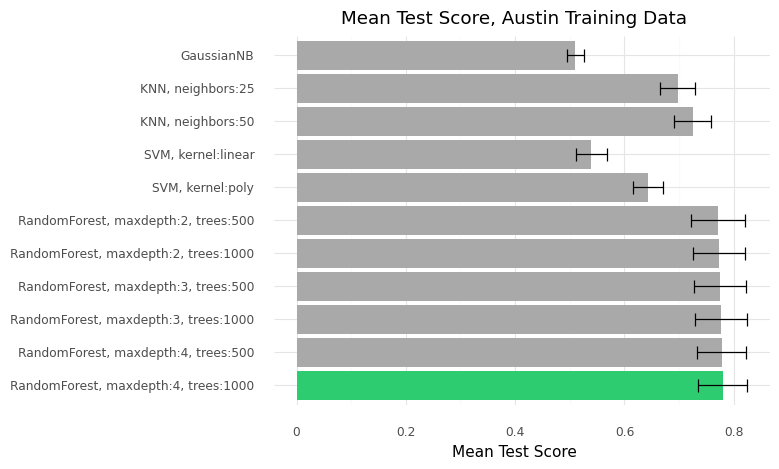

<ggplot: (8763929469504)>

In [9]:
# plot the average test score results
(
ggplot(table, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','#2ecc71'), guide=None) + 
    scale_x_discrete(limits=(
    'RandomForest, maxdepth:4, trees:1000',
    'RandomForest, maxdepth:4, trees:500',    
    'RandomForest, maxdepth:3, trees:1000', 
    'RandomForest, maxdepth:3, trees:500',
    'RandomForest, maxdepth:2, trees:1000',
    'RandomForest, maxdepth:2, trees:500',
    'SVM, kernel:poly',
    'SVM, kernel:linear',
    'KNN, neighbors:50',
    'KNN, neighbors:25',
    'GaussianNB'
    )) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title='Mean Test Score, Austin Training Data') + 
    theme_minimal()
)